In [3]:
from sklearnex import patch_sklearn, config_context

patch_sklearn()

import cv2
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import os
import matplotlib.pyplot as plt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
# Read images and masks

images = []
masks = []

for i in range(1, 15):
    img = cv2.imread('./CHASEDB1/Image_' + str(i).zfill(2) + 'L.jpg')
    mask = cv2.imread('./CHASEDB1/Image_' + str(i).zfill(2) + 'L_1stHO.png', cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print('Cannot read mask')
        exit(0)

    if img is None:
        print('Cannot read image')
        exit(0)

    images.append(img)
    masks.append(mask)

In [5]:
# Extract features and labels

def extract_features(crop):
    features = []

    var = np.var(crop)
    features.append(var)
    
    moments = cv2.moments(crop)
    hu = cv2.HuMoments(moments).flatten()

    features.extend(hu)
           
    return np.array(features)

def extract_labels(crop):
    if crop[2, 2] > 225:
        return 1
    else:
        return 0

In [6]:
# Image preprocessing
# Prepare data for training

X = []
y = []

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for mask in masks:
    
    for i in range(2, mask.shape[0] - 2):
        for j in range(2, mask.shape[1] - 2):
            crop = mask[i - 2:i + 3, j - 2:j + 3]
            y.append(extract_labels(crop))

for image in images:

    image = image[:, :, 1]
    image = clahe.apply(image)

    for i in range(2, image.shape[0] - 2):
        for j in range(2, image.shape[1] - 2):
            crop = image[i - 2:i + 3, j - 2:j + 3]
            X.append(extract_features(crop))
            
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
# Build pipeline

knn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='ball_tree')

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', knn)
])

In [ ]:
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('knn', KNeighborsClassifier())
# ])


# param_grid = {
#     'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
#     'knn__weights': ['uniform', 'distance'],
#     'knn__algorithm': ['ball_tree', 'kd_tree', 'brute']
# }

# grid = GridSearchCV(pipeline, param_grid)

In [18]:
# Model training

with config_context(target_offload="auto"):
    pipeline.fit(X_train, y_train)

print('Training accuracy:', pipeline.score(X_train, y_train))
print('Test accuracy:', pipeline.score(X_test, y_test))

None
None
Training accuracy: 0.9553250412252536
None
Test accuracy: 0.9295290959679849


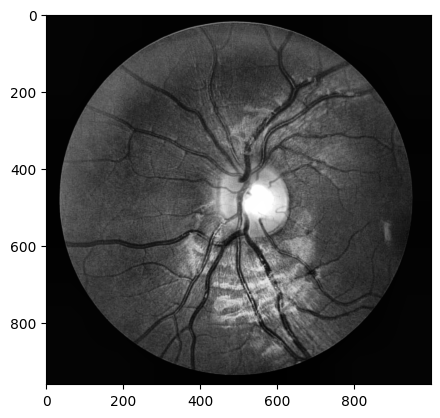

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


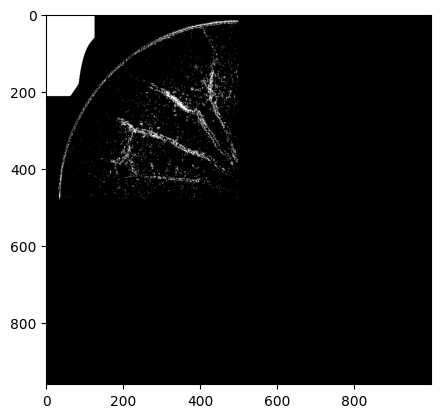

True

In [33]:
# Use model to predict new image

new_img = cv2.imread('./CHASEDB1/Image_10L.jpg')

b, g, r = cv2.split(new_img)
new_img = g
new_img = np.clip(new_img, 10, 245)
new_img = clahe.apply(new_img)
plt.imshow(new_img, cmap='gray')
plt.show()

new_mask = np.zeros((new_img.shape[0], new_img.shape[1]), dtype=np.uint8)

for i in range(2, new_mask.shape[0] // 2, 1):
    for j in range(2, new_mask.shape[1] //2, 1):
        window = new_img[i-2:i+3, j-2:j+3]
        features = extract_features(window)
        label = pipeline.predict([features])[0]
        new_mask[i, j] = label if label == 1 else 0

new_mask = np.where(new_mask == 1, 255, 0).astype(np.uint8)

plt.imshow(new_mask, cmap='gray')
plt.show()

if os.path.exists('new_mask.jpg'):
    os.remove('new_mask.jpg')

cv2.imwrite('new_mask.jpg', new_mask)